In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from scipy.optimize import curve_fit

The idea is to record the number of reps until failure for increasing weight for each muscle group. The result will be a _strength curve_, the shape of which should correlate to the strength-fatigure ratio of a muscle. Each data point is recorded at the beginning of a workout session under similar conditions and prior to the onset of fatigue to avoid bias. 

The following notebook will serve as a development environment for the forthcoming analysis, while data accumulation is ongoing. Data collection will take a few weeks. In the meantime I will set up the analysis with palceholder data such that when the data collection is complete analysis will be as simple as plug and play. 

Goals of the notebook:

1. Figure out how to save and format the data for each muscle group 
2. Write out some analysis tools to pass data into

In [5]:
# example data 

# data in the form weight, reps
bench = [[45,70],[95,35],[135,26],[185,12],[225,4],[245,1]]
squat = [[135,37],[185,28],[225,22],[275,14],[315,9],[365,3],[405,1]]

# add the data to hdf5 file as datasets
with h5py.File('data/strength_curve_adam_smith_orlik.h5','w') as f:
    # attributes for weight, height, date
    f.attrs['weight'] = 200
    f.attrs['height'] = 70
    f.attrs['date'] = '2018-10-01'
    # datasets for bench and squat
    f.create_dataset('bench', data=bench)
    f.create_dataset('squat', data=squat)


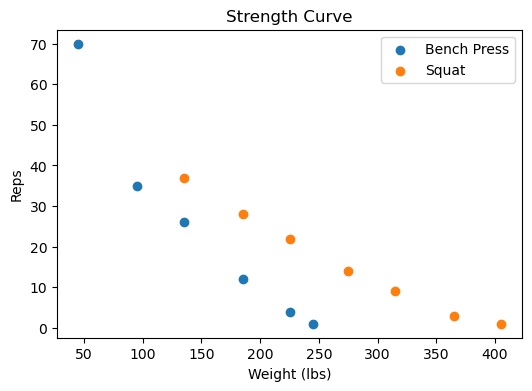

In [6]:
# read the data from the hdf5 file into a pandas dataframe

with h5py.File('data/strength_curve_adam_smith_orlik.h5','r') as f:
    # get the attributes
    weight = f.attrs['weight']
    height = f.attrs['height']
    date = f.attrs['date']
    # get the datasets
    bench = f['bench'][:]
    squat = f['squat'][:]

# create a pandas dataframe
dfb = pd.DataFrame(data=bench, columns=['weight','reps'])
dfs = pd.DataFrame(data=squat, columns=['weight','reps'])

# plot the data
plt.figure(figsize=(6,4))

plt.scatter(dfb['weight'], dfb['reps'], color='C0', label='Bench Press')
plt.scatter(dfs['weight'], dfs['reps'], color='C1', label='Squat')
plt.xlabel('Weight (lbs)')
plt.ylabel('Reps')
plt.title('Strength Curve')
plt.legend()

plt.show()

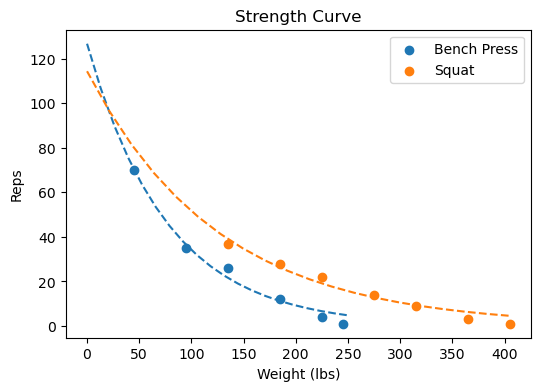

In [41]:
def exp_model(w, a, b):
    return a * np.exp(-b*w)

params_b, cov_b = curve_fit(exp_model, dfb['weight'], dfb['reps'], p0=[70, 0.01])
params_s, cov_s = curve_fit(exp_model, dfs['weight'], dfs['reps'], p0=[37, 0.01])

a_b, b_b = params_b
a_s, b_s = params_s

weights_b = np.linspace(0, 250, 20)
weights_s = np.linspace(0, 405, 20)

plt.figure(figsize=(6,4))

plt.scatter(dfb['weight'], dfb['reps'], color='C0', label='Bench Press')
plt.scatter(dfs['weight'], dfs['reps'], color='C1', label='Squat')
plt.plot(weights_b, exp_model(weights_b, a_b, b_b), color='C0', linestyle='--')
plt.plot(weights_s, exp_model(weights_s, a_s, b_s), color='C1', linestyle='--')
plt.xlabel('Weight (lbs)')
plt.ylabel('Reps')
plt.title('Strength Curve')
plt.legend()
# add the fit parameters to a text box in the plot
# plt.text(0.5, 0.5, 'Bench Press: a={:.2f}, b={:.2f}\nSquat: a={:.2f}, b={:.2f}'.format(a_b, b_b, a_s, b_s), transform=plt.gca().transAxes)

plt.show()


In [17]:
print(f'Bench Press: a={a_b:.2f}, b={b_b:.4f}')
print(f'Squat: a={a_s:.2f}, b={b_s:.4f}')

Bench Press: a=126.70, b=0.0131
Squat: a=114.34, b=0.0080


In [43]:
# reduced chi-squared for the fits
def red_chi_sq(y, y_fit, n, p):
    return np.sum((y - y_fit)**2) / (n - p)

n_b = len(dfb['weight'])
n_s = len(dfs['weight'])
p = 2

y_fit_b = exp_model(dfb['weight'], a_b, b_b)
y_fit_s = exp_model(dfs['weight'], a_s, b_s)

chi_sq_b = red_chi_sq(dfb['reps'], y_fit_b, n_b, p)
chi_sq_s = red_chi_sq(dfs['reps'], y_fit_s, n_s, p)

print(f'Bench Press: reduced chi-squared = {chi_sq_b:.2f}')
print(f'Squat: reduced chi-squared = {chi_sq_s:.2f}')

Bench Press: reduced chi-squared = 11.52
Squat: reduced chi-squared = 8.13


Conclusions:

My chest has better endurance (blue curve crosses orange for low weights) than my legs, but my legs show a slower rate of decline in strength as weight is added. 

Try a power law with linearized data

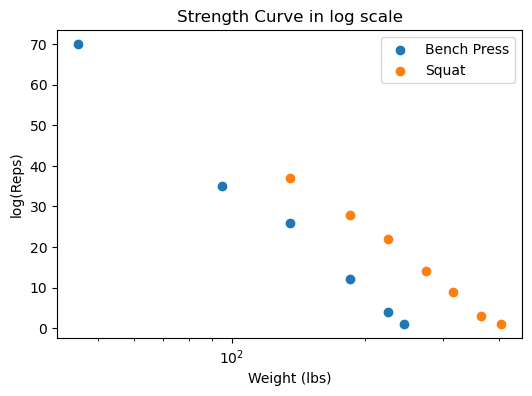

In [22]:
# plot the log of the data

plt.figure(figsize=(6,4))

plt.scatter(dfb['weight'], dfb['reps'], color='C0', label='Bench Press')
plt.scatter(dfs['weight'], dfs['reps'], color='C1', label='Squat')
plt.xlabel('Weight (lbs)')
plt.ylabel('log(Reps)')
plt.title('Strength Curve in log scale')
plt.xscale('log')
plt.legend()

plt.show()

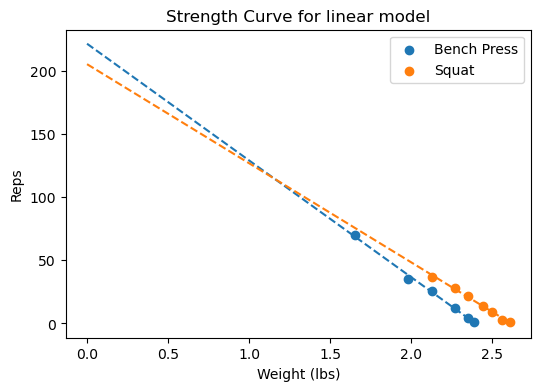

In [44]:
# fit linear model to the log data

def linear_model(w, a, b):
    return -a*w + b

params_b, cov_b = curve_fit(linear_model, np.log10(dfb['weight']), dfb['reps'], p0=[10, 10])
params_s, cov_s = curve_fit(linear_model, np.log10(dfs['weight']), dfs['reps'], p0=[10, 10])

a_b, b_b = params_b
a_s, b_s = params_s

weights_b = np.log10(np.linspace(1, 250, 20))
weights_s = np.log10(np.linspace(1, 405, 20))

plt.figure(figsize=(6,4))

plt.scatter(np.log10(dfb['weight']), dfb['reps'], color='C0', label='Bench Press')
plt.scatter(np.log10(dfs['weight']), dfs['reps'], color='C1', label='Squat')
plt.plot(weights_b, linear_model(weights_b, a_b, b_b), color='C0', linestyle='--') 
plt.plot(weights_s, linear_model(weights_s, a_s, b_s), color='C1', linestyle='--')
plt.xlabel('Weight (lbs)')
plt.ylabel('Reps')
plt.title('Strength Curve for linear model')
# plt.xscale('log')
plt.legend()

plt.show()

In [45]:
print(f'Bench Press: a={a_b:.2f}, b={b_b:.4f}')
print(f'Squat: a={a_s:.2f}, b={b_s:.4f}')

Bench Press: a=92.40, b=221.3116
Squat: a=78.42, b=205.1299


In [46]:
# reduced chi-squared for the fits

y_fit_b = linear_model(np.log10(dfb['weight']), a_b, b_b)
y_fit_s = linear_model(np.log10(dfs['weight']), a_s, b_s)

chi_sq_b = red_chi_sq(dfb['reps'], y_fit_b, n_b, p)
chi_sq_s = red_chi_sq(dfs['reps'], y_fit_s, n_s, p)

print(f'Bench Press: reduced chi-squared = {chi_sq_b:.2f}')
print(f'Squat: reduced chi-squared = {chi_sq_s:.2f}')

Bench Press: reduced chi-squared = 4.35
Squat: reduced chi-squared = 0.99


This again shows the same. In the linear model the intercept represents the scale of endurance, bench press being higher than squat for very low reps. the slope represents the decline of strength, with the bench haveing a higher slope indicating a quicker fall of for strength compared to squats. 

Also, the linear model fits better based on the reduced chi squared. This may not be the case when the real data is inputted. 

When the real data is inputted I can test both models again to see which best represents real data across different exercises and muscle groups. 